# Chroma-Multimodal

- Author: [Gwangwon Jung](https://github.com/pupba)
- Design: []()
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/09-VectorStore/02-Chroma-Multimodal.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/09-VectorStore/02-Chroma-Multimodal.ipynb)

## Overview

This tutorial covers how to use `Chroma Multimodal Vector Store` with `LangChain` .

In this tutorial, we will inherit the `ChromaDB` class from the previous tutorial to create a class that adds a `Multimodal` feature, and then use this class to implement an example of a **multimodal search** engine.

![search-example](./assets/02-chroma-with-langchain-flow-search-example.png)

### Table of Contents

- [Overview](#overview)
- [Environement Setup](#environment-setup)
- [Multimodal Search](#multimodal-search)
- [Create a Multimodal Vector Store](#create-a-multimodal-vector-store)
- [Image Searching](#image-searching)


### References

- [Chroma Docs](https://docs.trychroma.com/docs/overview/introduction)
- [Langchain-Chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma/)
- [List of VectorStore supported by Langchain](https://python.langchain.com/docs/integrations/vectorstores/)
----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain-core",
        "langchain-chroma",
        "langchain-huggingface",
        "langchain-experimental",
        "chromadb",
        "pillow",
        "open_clip_torch",
        "scikit-learn",
        "numpy",
        "requests",
        "pydantic",
        "python-dotenv",
        "datasets >= 3.2.0",  # Requirements >= 3.2.0
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Chroma With Langchain",  # title 과 동일하게 설정해 주세요
        "HUGGINGFACEHUB_API_TOKEN": "",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Multimodal Search

`Chorma` supports `Multimodal Collections` , which means it can handle and store embeddings from different types of data, such as `text` , `images` , `audio` , or even `video` .

We can search for `images` using `Chroma` .

### Setting image and image_info data

This dataset is made by `SDXL` . 

**Dataset: Animal-180**

- [animal-180](https://huggingface.co/datasets/Pupba/animal-180)

This dataset, named `animal-180` , is a collection of 180 realistic animal images generated using `Stable-Diffusion XL(SDXL)` .

It includes images of `lions` , `rabbits` , `cats` , `dogs` , `elephants` and `tigers` , with 30 images per animal category.

All images are free to use for any purpose, as they are synthetically generated and not subject to copyright restrictions.

In [5]:
import tempfile
from PIL import Image


def save_temp_gen_url(image: Image) -> str:
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
    image.save(temp_file, format="PNG")
    temp_file.close()
    return temp_file.name

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Pupba/animal-180", split="train")

# slice 50 set
images = dataset[:50]["png"]
image_paths = [save_temp_gen_url(img) for img in images]
metas = dataset[:50]["json"]
prompts = [data["prompt"] for data in metas]
categories = [data["category"] for data in metas]

Image Path: C:\Users\Jung\AppData\Local\Temp\tmpe8qbwa9a.png
Prompt: a fluffy white rabbit sitting in a grassy meadow, soft sunlight illuminating its fur, highly detailed, 8k resolution.
Category: rabbit


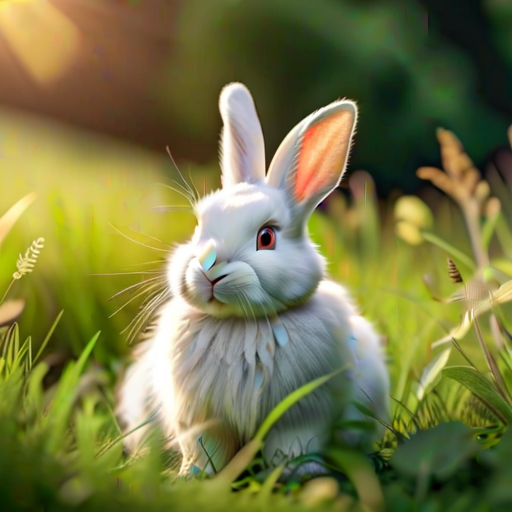

In [7]:
print("Image Path:", image_paths[0])
print("Prompt:", prompts[0])
print("Category:", categories[0])
images[0]

Load `OpenCLIP` for `Multimodal Embedding` .

- [OpenCLIP](https://github.com/mlfoundations/open_clip/tree/main)

In [8]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings

MODEL = "ViT-B-16-quickgelu"
CHECKPOINT = "openai"

multimodal_embedding = OpenCLIPEmbeddings(model_name=MODEL, checkpoint=CHECKPOINT)

## Create a Multimodal Vector Store

Define the `ChromaDB` class created in the previous tutorial.

In [9]:
from utils.vectordbinterface import VectorDBInterface
from langchain_chroma import Chroma
from langchain_chroma.vectorstores import cosine_similarity
from langchain_core.vectorstores.base import VectorStoreRetriever
import chromadb
from chromadb.utils import embedding_functions
from langchain_core.documents import Document
from typing import List, Dict, Any, Optional, Union, Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed
from uuid import uuid4


class ChromaDB(VectorDBInterface):
    def __init__(self, embeddings: Optional[Any] = None):
        self.chroma = None
        self.unique_ids = set()
        self._embeddings = embeddings if embeddings is not None else None
        self._embeddings_function = (
            embeddings.embed_documents
            if embeddings is not None
            else embedding_functions.DefaultEmbeddingFunction()  # all-MiniLM-L6v2
        )
        self.chroma_search = None

    def connect(self, **kwargs) -> None:
        """
        ChromaDB Connect
        """
        langchain_config = {}

        if kwargs["mode"] == "in-memory":  # In-Memory
            chroma_client = chromadb.Client()

        elif kwargs["mode"] == "persistent":  # Local
            chroma_client = chromadb.PersistentClient(path=kwargs["persistent_path"])
            langchain_config["persist_directory"] = kwargs["persistent_path"]

        elif kwargs["mode"] == "server":  # Server-Client
            chroma_client = chromadb.HttpClient(
                host=kwargs["host"], port=kwargs["port"]
            )
        else:
            raise Exception(
                "Invalid Input, Enter one of ['in-meory','persistent','server'] modes."
            )

        # The Chroma client allows you to get and delete existing collections by their name.
        # It also offers a get or create method to get a collection if it exists, or create it otherwise.

        # l2(default) : squared L2 norm
        # ip : Inner Product
        # cosine : Cosine Distance
        metadata = {
            "hnsw:space": (
                kwargs.get("hnsw:space") if kwargs.get("hnsw:space", None) else "l2"
            )
        }

        self.chroma = chroma_client.get_or_create_collection(
            name=kwargs["collection"], metadata=metadata
        )

        langchain_config["collection_name"] = kwargs["collection"]
        langchain_config["collection_metadata"] = metadata

        existing_ids = self.chroma.get(include=[])["ids"]  # Get existing unique ids
        self.unique_ids.update(existing_ids)  # current unique ids update

        # Langchain-chroma for Search
        self.chroma_search = Chroma(
            **langchain_config,
            embedding_function=self._embeddings,
        )

    def create_index(
        self, index_name: str, dimension: int, metric: str = "dotproduct", **kwargs
    ) -> Any:
        """
        Not used in Chroma
        """
        return None

    def get_index(self, index_name: str) -> Any:
        """
        Not used in Chroma
        """
        return None

    def delete_index(self, index_name: str) -> None:
        """
        Not used in Chroma
        """
        return None

    def list_indexs(self) -> List[str]:
        """
        Not used in Chroma
        """
        return None

    def add(self, pre_documents: List[Document], **kwargs) -> None:
        documents = []
        metadatas = []
        ids = []
        for doc in pre_documents:
            documents.append(doc.page_content)
            ids.append(doc.metadata["id"])
            metadatas.append(
                {key: value for key, value in doc.metadata.items() if key != "id"}
            )

        embeddings = self._embeddings_function(documents)  # embedding documents

        self.chroma.add(
            documents=documents,
            embeddings=embeddings,
            metadatas=metadatas,
            ids=ids,
        )
        self.unique_ids.update(ids)

    def upsert_documents(
        self,
        documents: List[Dict],
        **kwargs,
    ) -> None:
        """
        Upsert documents to Chroma

        :param documents: List of documents
        :param embedding_function: Embedding function
        """
        # Embedding documents
        embeddings = self._embeddings_function([doc.page_content for doc in documents])
        # Generate unique ids
        unique_ids = [doc.metadata["id"] for doc in documents]
        # Upsert documents
        self.chroma.upsert(
            ids=unique_ids,
            embeddings=embeddings,
            metadatas=[doc.metadata for doc in documents],
            documents=[doc.page_content for doc in documents],
        )

        print("Success Upsert All Documents")

        # update unique_ids
        self.unique_ids.update(unique_ids)

    def upsert_documents_parallel(
        self,
        documents: List[Dict],
        batch_size: int = 32,
        max_workers: int = 10,
        **kwargs,
    ) -> None:
        """
        Parallel upsert documents to Chroma
        :param documents: List of documents
        :param batch_size: Batch size
        :param max_workers: Number of workers
        """
        # split documents into batches
        batches = [
            documents[i : i + batch_size] for i in range(0, len(documents), batch_size)
        ]
        all_unique_ids = set()  # Store all unique IDs from all batches
        failed_uids = []  # Store failed batches

        # Parallel processing
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [
                executor.submit(self.upsert_documents, batch, **kwargs)
                for batch in batches
            ]

        # Wait for all futures to complete
        for future, batch in zip(as_completed(futures), batches):
            try:
                future.result()  # Wait for the batch to complete
                # Extract unique IDs from the batch
                unique_ids = [doc.metadata["id"] for doc in batch]
                all_unique_ids.update(unique_ids)  # Add to the total set
            except Exception as e:
                print(f"An error occurred during upsert: {e}")
                failed_uids.append(unique_ids)  # Store failed batch for retry

        self.unique_ids.update(all_unique_ids)

        print(f"Success Upsert Parallel All Documents\nFailed Batches: {failed_uids}")

    def _cosine_similarity_search_text(
        self, query: str, configs: Dict
    ) -> List[Tuple[Document, float]]:
        """
        Hybrid Search : Text Search + Cosine Similarity
        """
        docs = self.chroma_search.similarity_search(**configs)

        embx = self._embeddings.embed_query(query)
        emb_d = self._embeddings.embed_documents([doc.page_content for doc in docs])

        scores = cosine_similarity([embx], emb_d)

        return sorted(
            [(doc, score) for score, doc in zip(scores[0], docs)],
            key=lambda x: x[1],
            reverse=True,
        )

    def query(
        self,
        query: str,
        top_k: int = 10,
        score: bool = False,
        filters: Optional[Dict[str, str]] = None,
        where_document: Optional[Dict[str, str]] = None,
        cs: bool = False,
        **kwargs,
    ) -> Union[List[Document], List[Tuple[Document, float]]]:
        """
        A Method that implements a search method using a LangChain-Chroma library.
        """

        configs = {
            "query": query,
            "k": top_k,
            "filter": filters,
            **kwargs,
        }

        if score:
            configs["where_document"] = where_document
            results = self.chroma_search.similarity_search_with_score(
                **configs
            )  # distance search score

        elif cs:  # cosine similarity search
            return self._cosine_similarity_search_text(query, configs)
        else:
            results = self.chroma_search.similarity_search(**configs)

        return results

    def delete_by_filter(
        self, unique_ids: List[str], filters: Optional[Dict] = None, **kwargs
    ) -> None:
        """
        Delete documents by filter
        :param unique_ids: List of unique ids
        :param filters: Filter conditions
        """
        try:
            self.chroma.delete(
                ids=unique_ids,
                where=filters,
            )
            pre_count = len(self.unique_ids)
            self.unique_ids = set(self.chroma.get(include=[])["ids"])

            print(f"Success Delete {pre_count-len(self.unique_ids)} Documents")

        except Exception as e:
            print(f"Error: {e}")

    def getRetriever(
        self, search_type: str = "mmr", search_kwargs: Optional[Dict] = None
    ) -> VectorStoreRetriever:
        """
        Get Retriever Method using a LangChain-Chroma library.

        Refer to the following document -> LangChain-Chroma Official Document.

        :param search_type: [similarity(default), mmr, similarity_score_threshold]
        :param search_kwargs: [k, fetch_k, lambda_mult, filter]
        """
        return self.chroma_search.as_retriever(
            search_type=search_type, search_kwargs=search_kwargs
        )

    def preprocess_documents(
        self,
        documents: List[Document],
        source: Optional[str] = None,
        author: Optional[str] = None,
        chapter: bool = False,
        **kwargs,
    ) -> List[Dict]:
        """
        Change LangChain Document to Chroma

        Refer to the following document -> LangChain-Chroma Official Document.

        :param documents: List of LangChain documents
        :param source: Source of the document
        :param author: Author of the document
        :param chapter: Chapter of the document
        :return: List of Chroma documents
        """
        metadata = {}

        if source is not None:
            metadata["source"] = source
        if author is not None:
            metadata["author"] = author

        processed_docs = []
        current_chapter = None
        save_flag = False
        for doc in documents:
            content = doc.page_content

            content = content.replace("(picture)\n", "")

            # Chapter dectect
            if content.startswith("[ Chapter ") and "\n" in content:
                # Chapter Num (example: "[ Chapter 26 ]\n" -> 26)
                chapter_part, content_part = content.split("\n", 1)
                current_chapter = int(chapter_part.split()[2].strip("]"))
                content = content_part

            elif content.strip() == "[ END ]":
                break

            if current_chapter is not None:
                # add metadata
                if chapter:
                    metadata["chapter"] = current_chapter
                updated_metadata = {**doc.metadata, **metadata, "id": str(uuid4())}
                # Document append to processed_docs
                processed_docs.append(
                    Document(metadata=updated_metadata, page_content=content)
                )

        return processed_docs

    def get_api_key(self) -> str:
        """
        Not used in Chroma
        """
        return None

Define **Image Document Chroma** template.

In [10]:
from pydantic import BaseModel


class ImageMetadata(BaseModel):
    category: str
    prompt: str


class ImageDocumentChroma(BaseModel):
    id: str  # unique id
    image_uri: str  # image uri path
    metadata: Optional[ImageMetadata] = None  # Metadata

Inherit the class to create a child class that adds the **Multimodal** method.

In [11]:
import base64
import io
from langchain_chroma.vectorstores import cosine_similarity
import tempfile

In [12]:
class ChromaMulitmodalDB(ChromaDB):
    def __init__(self, embeddings: Optional[Any] = None):
        super().__init__(embeddings)

    def add_images(
        self,
        image_documents: List[ImageDocumentChroma],
        **kwargs: Any,
    ) -> List[str]:
        """
        Langchain-Chroma 'add_images method' supports 'upsert' by default.
        """

        uris = []
        metadatas = []
        ids = []

        for docs in image_documents:
            ids.append(docs.id)
            uris.append(docs.image_uri)
            metadatas.append(docs.metadata.dict())
        ids = self.chroma_search.add_images(
            uris=uris, metadatas=metadatas, ids=ids, **kwargs
        )

        self.unique_ids.update(ids)
        return ids

    def upsert_images_parallel(
        self,
        image_uri_documents: List[ImageDocumentChroma],
        batch_size: int = 32,
        max_workers: int = 10,
        **kwargs,
    ) -> List[str]:

        batches = [
            image_uri_documents[i : i + batch_size]
            for i in range(0, len(image_uri_documents), batch_size)
        ]

        all_unique_ids = set()  # Store all unique IDs from all batches

        failed_uids = []  # Store failed batches

        # Parallel processing

        with ThreadPoolExecutor(max_workers=max_workers) as executor:

            futures = [
                executor.submit(self.add_images, batch, **kwargs) for batch in batches
            ]

        # Wait fo all futures to complete
        for future, batch in zip(as_completed(futures), batches):
            try:
                ids = future.result()  # Wait for the batch to complete
                # Extract unique IDs from the batch
                unique_ids = [i for i in ids]
                all_unique_ids.update(unique_ids)  # Add to the total set
            except Exception as e:
                print(f"An error occurred during upsert: {e}")
                failed_uids.append(unique_ids)  # Store failed batch for retry

        self.unique_ids.update(all_unique_ids)

        return all_unique_ids

    def preprocess_image_documents(
        self, uris: List[str], prompts: List[str], categories: List[str]
    ) -> List[ImageDocumentChroma]:

        documents = [
            ImageDocumentChroma(
                **{
                    "id": str(uuid4()),
                    "image_uri": uri,
                    "metadata": ImageMetadata(
                        **{"prompt": prompt, "category": category}
                    ),
                }
            )
            for uri, prompt, category in zip(uris, prompts, categories)
        ]

        return documents

    def searching_text_query(
        self, text_query: str, k: int = 1
    ) -> List[Tuple[float, List[ImageDocumentChroma]]]:
        docs = self.chroma_search.as_retriever(search_kwargs={"k": k}).invoke(
            text_query
        )

        # cosine_similarity
        emq = self._embeddings.embed_query(text_query)
        emdocs = self._embeddings.embed_image(
            [self.getURIfromPILImage(self.toPIL(doc.page_content)) for doc in docs]
        )
        scores = sorted(cosine_similarity([emq], emdocs)[0], reverse=True)

        return [
            (
                score,
                ImageDocumentChroma(
                    **{
                        "id": doc.id,
                        "image_uri": doc.page_content,
                        "metadata": ImageMetadata(
                            **{
                                "category": doc.metadata["category"],
                                "prompt": doc.metadata["prompt"],
                            }
                        ),
                    }
                ),
            )
            for score, doc in zip(scores, docs)
        ]

    def search_image_query(
        self, image_uri: str, k: int = 1, filters: Optional[Dict] = None
    ) -> List[Tuple[float, List[ImageDocumentChroma]]]:
        docs = self.chroma_search.similarity_search_by_image(
            uri=image_uri, k=k, filter=filters
        )

        # cosine_similarity
        emq = self._embeddings.embed_image([image_uri])
        emdocs = self._embeddings.embed_image(
            [self.getURIfromPILImage(self.toPIL(doc.page_content)) for doc in docs]
        )
        scores = sorted(cosine_similarity(emq, emdocs)[0], reverse=True)

        return [
            (
                score,
                ImageDocumentChroma(
                    **{
                        "id": doc.id,
                        "image_uri": doc.page_content,
                        "metadata": ImageMetadata(
                            **{
                                "category": doc.metadata["category"],
                                "prompt": doc.metadata["prompt"],
                            }
                        ),
                    }
                ),
            )
            for score, doc in zip(scores, docs)
        ]

    def toPIL(self, image_str: str) -> Image.Image:
        image_data = base64.b64decode(image_str)
        image = Image.open(io.BytesIO(image_data))
        return image

    def getURIfromPILImage(self, image: Image) -> str:
        # Create a temporary file
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".jpg")
        image.save(temp_file, format="JPEG")

        # Close the file to allow other processes to access it
        temp_file.close()
        return temp_file.name

In [13]:
vector_store = ChromaMulitmodalDB(embeddings=multimodal_embedding)

configs = {
    "mode": "persistent",
    "persistent_path": "data/chroma",
    "collection": "test",
    "hnsw:space": "cosine",
}

vector_store.connect(**configs)

### Adding **Multimodal Data** to vector store.

Preprocess mutimodal data.

In [14]:
image_documents = vector_store.preprocess_image_documents(
    uris=image_paths, prompts=prompts, categories=categories
)
image_documents[0]

ImageDocumentChroma(id='6acf30c8-bf93-4f22-86b0-9239d2efcb09', image_uri='C:\\Users\\Jung\\AppData\\Local\\Temp\\tmpe8qbwa9a.png', metadata=ImageMetadata(category='rabbit', prompt='a fluffy white rabbit sitting in a grassy meadow, soft sunlight illuminating its fur, highly detailed, 8k resolution.'))

In [15]:
len(image_documents)

50

Adding `ImageDocumentChroma` data to vector store.

`add_images()` , the method of `LangChain-Chroma` , supports `upsert` by default.

In [16]:
ids = vector_store.add_images(image_documents=[image_documents[0]])
ids
vector_store.chroma.get(ids=ids)

{'ids': ['6acf30c8-bf93-4f22-86b0-9239d2efcb09'],
 'embeddings': None,
 'documents': ['iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAEAAElEQVR4nJT9CbNsa3Idhu2pqs45dx7eu2/qEQ1iIqZGgwBBiAABDpAsEhSHoChTpBmy/ccc/hEOhR0KBynZdFgyRILobgA9vn7zcN8dz6mqvbcjc62VmV+d2wz7oHHfGap27f19+eWwcmVm//7//M9v3j703TD0U9dtR/t36PuhG4aut//1/dAPfdevfd933dp162r/LvarxX+zLvbTav9bl65bBvt+GbpuWu01w7r09p61X/z7ZRnmpbNfLt1ib+zWZZ33h+VwOF7u5+M87+fluCzzss7rsqzr2i32XvtYv87Km8DXom/8D/Yn/cZeZf929t6uW/zul3X1/9l1cXnei3/SrMvYh9ovcAN44nWxK3fL0i3+zmXtZn8DbtIep+v8Ev43XHuZ7X/rbB9iy7B0vk7rsM7TOo/rcermYZ2HbrVlGzpbUV+9dbAlX/phtn87/Ou/9Ie0a8WX/ULf2FP3vS/qap/lD2bf+LrYhsy+jl3X2Q31vq22/WvX9/2wdLbhXd/1o/2+G9Zu6Ox/fdf1q/3Yd/2wrv3aD/6xeOMwrj2ExF/pV9c3Xe+3bH/Om/RHgPj4a/EKu8l4Cvxj7/UL+UXsj/Z0/j1fsdrd2BZAZub5uNge+Y74K1b7aHyQFgwLYP/aIuhiWFpem3fr3/pvff/wgHZDvm6+AnjYeGy8yL71C/kK65n5kvzX7k1/wJ76L7S7uBVfm/plR8KXq1/8j4sfJH9GE70UYjwrv3o/Q/5uXyA/CC4o+B9Okx8YOyd452ICZ6+zf12EuEL26f4Rvsp6IhcGLI9LlkkFF2fAzyZl+JXvS3kyLoUJhhbTH1Mbb3qgLAnP6tL7ubOl4L249NuZM9E/+

Using `upsert_images_parallel()`

In [17]:
ids = vector_store.upsert_images_parallel(
    image_uri_documents=image_documents, batch_size=32, max_workers=5
)
len(ids)

50

## Image Searching

We can perform image retrieval in two ways.

- Text Query Search
- Image Query Search

### Text Query Search

Use Text query to search for images similar to those described by the text.

In [18]:
from IPython.display import display

In [19]:
def show_docs(results: List) -> None:
    for idx, (score, docs) in enumerate(results):
        print(f"Rank[{idx+1}]")
        print(f"Category: {docs.metadata.category}")
        print(f"Prompt: {docs.metadata.prompt}")
        print(f"Cosine Similarity Score: {score:.3f}")
        display(vector_store.toPIL(docs.image_uri))
        print()

Rank[1]
Category: elephant
Prompt: an elephant walking through tall grass, golden sunlight reflecting off its skin, highly detailed, natural lighting, ultra-realistic.
Cosine Similarity Score: 0.310


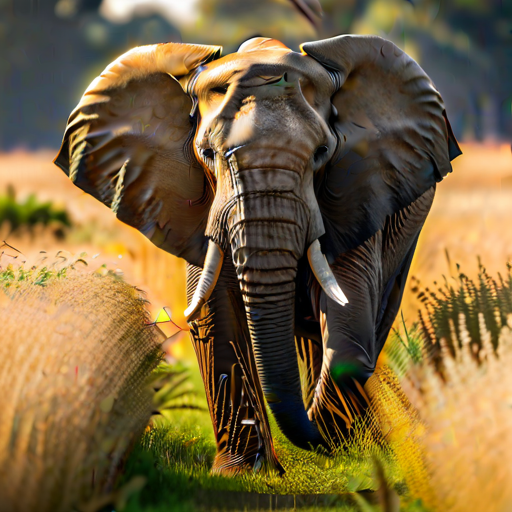


Rank[2]
Category: elephant
Prompt: an elephant roaring in the early morning light, mist in the background, highly detailed, ultra-realistic, 8k resolution.
Cosine Similarity Score: 0.308


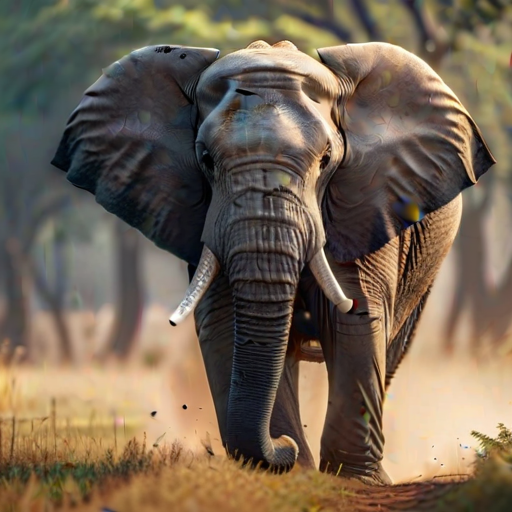

In [20]:
results = vector_store.searching_text_query(text_query="a elephant run", k=2)

show_docs(results)

### Image Query Search

Search for images that are similar to the images.

In [21]:
# query image url
import requests


def load_image_from_url(url: str, resolution: int = 512) -> Image.Image:
    """
    Load an image from a URL and return it as a PIL Image object.

    Args:
        url (str): The URL of the image.

    Returns:
        Image.Image: The loaded PIL Image object.
    """
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for failed requests
    image = Image.open(io.BytesIO(response.content))
    image = image.resize((resolution, resolution), resample=Image.Resampling.LANCZOS)
    return image


def save_image_to_tempfile(url: str) -> str:
    """
    Download an image from a URL and save it to a temporary file.

    Args:
        url (str): The URL of the image.

    Returns:
        str: The file path to the saved image.
    """
    response = requests.get(url)

    # Raise an error for failed requests
    response.raise_for_status()

    # Create a temporary file
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".jpg")
    temp_file.write(response.content)

    # Close the file to allow other processes to access it
    temp_file.close()
    return temp_file.name

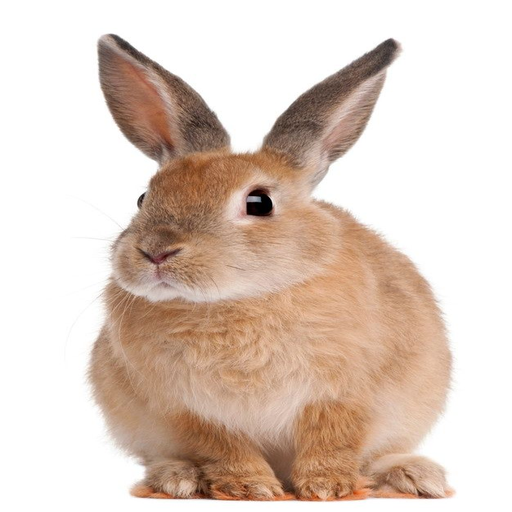

In [22]:
# rabbit image
img_url = "https://i.pinimg.com/736x/b2/e9/f4/b2e9f449c1c5f8a29e31cafb8671c8b2.jpg"

image_query = load_image_from_url(img_url)
image_query_url = save_image_to_tempfile(img_url)

image_query

Rank[1]
Category: rabbit
Prompt: a rabbit sitting on a stone wall, looking at the camera, soft natural lighting, highly detailed, ultra-realistic.
Cosine Similarity Score: 0.913


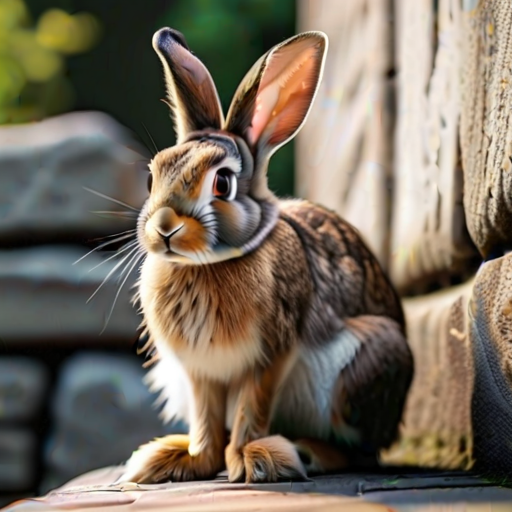


Rank[2]
Category: rabbit
Prompt: a rabbit standing on its hind legs, looking at the camera, soft golden lighting, highly detailed, 8k resolution.
Cosine Similarity Score: 0.885


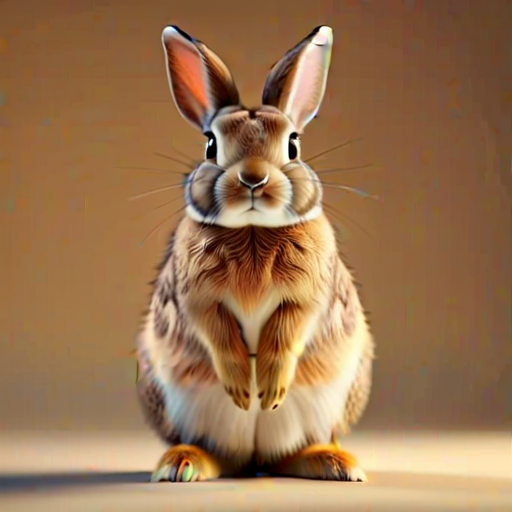

In [23]:
results = vector_store.search_image_query(
    image_uri=image_query_url, k=2, filters={"category": "rabbit"}
)

show_docs(results=results)

Remove a `Huggingface Cache`

In [24]:
dataset.cleanup_cache_files()

0

Disconnect `Chroma` DB and Remove Local DB file

In [25]:
del vector_store